### Notebook Authors:

- Andres Ruiz Calvo (100406604)
- Simon E. Sanchez Viloria (100381352)



# Lab 4 (Part 1): RNNs for Time Series Prediction


------------------------------------------------------
*Neural Networks. Bachelor in Data Science and Engineering*

*Pablo M. Olmos pamartin@ing.uc3m.es*

*Aurora Cobo Aguilera acobo@tsc.uc3m.es*

------------------------------------------------------


In this notebook, you will deploy a simple probabilistic model using a RNN to infer the probability distribution of a time-series. Given a set of signals $\mathcal{D}=\{X^1,X_2,\ldots,X_N\}$ where 
$$X^i = [X_0^i,X_1^i,\ldots,X_T^i]$$
is the $i$-th signal, we will train a probabilistic model of the form
$$p(X|X_0) = \prod_{t=0}^T p(X_t|X_{t-1},X_{:t-1})$$
where each factor is a Gaussian distribution with variance $\sigma^2$ and mean given by **the ouput of a RNN** with input $X_{t-1}$. Hence $X_{:t-1}$ in the conditional probability $p(X_t|X_{t-1},X_{:t-1})$ is embedded through the **RNN** state $\mathbf{h}_{t-1}$:

$$p(X_t|X_{t-1},X_{:t-1}) = \mathcal{N}\left(f_{RNN}(X_{t-1},\mathbf{h}_{t-1}),\sigma^2\right)$$

During training, for $t=1,\ldots,T$, we will sample $\hat{X}_t$ from $p(X_t|X_{t-1},X_{:t-1})$ and minimize the average square loss $\frac{1}{T}\sum_{t=1}^T(X_t-\hat{X}_t)^2$. Then we average again for all signals in the training set. Note that during training we **feed the RNN with the true values of the signal** $X^i = [X_0^i,X_1^i,\ldots,X_T^i]$. 




In [1]:
import torch
from torch import nn
from torch import optim
import numpy as np
import time
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'  #To get figures with high quality!


## Part I. Create a synthetic database




We will generate $N$ target signals of length $T$ time steps. We generate each signal as one realization of the following autoregressive model
\begin{align}
X_{t}=c+\sum_{i=1}^{p} \varphi_{i} X_{t-i}+\varepsilon_{t}
\end{align}



In [2]:
N = 1000 # Number of signals

T = 200

c = 0

phi_1 = 1

phi_2 = -1

phi_3 = 1

sigma = 1

X = np.zeros([N,T])

np.random.seed(23)

X[:,0] = c + np.random.randn(N,)*np.sqrt(sigma)

X[:,1] = c + phi_1 * X[:,0] + np.random.randn(N,)*np.sqrt(sigma)

X[:,2] = c + phi_1 * X[:,1] + phi_2 * X[:,0] + np.random.randn(N,)*np.sqrt(sigma)

X[:,3] = c + phi_1 * X[:,2] + phi_2 * X[:,1] + phi_3 * X[:,0] + np.random.randn(N,)*np.sqrt(sigma)

t = 4

while (t<T):

    X[:,t] = c + phi_1 * X[:,t-1] + phi_2 * X[:,t-2] + phi_3 * X[:,t-3] + np.random.randn(N,)*np.sqrt(sigma)
    
    t +=1
    

# Create targets

Y = X[:,1:] # all but the first
X = X[:,:-1] # all but the last piece of data

T -=1

The goal of the RNN will be to predict the value of the signal in the next time point given the current observation. Note that the noise in the model

$$p(X_t|X_{t-1},X_{:t-1}) = \mathcal{N}\left(f_{RNN}(X_{t-1},\mathbf{h}_{t-1}),\sigma^2\right)$$

will simply introduce an error that will prevent the model from overfitting. 

Lets plot one of the signals versus the *target*, which is the same signal but shifted to the right ...

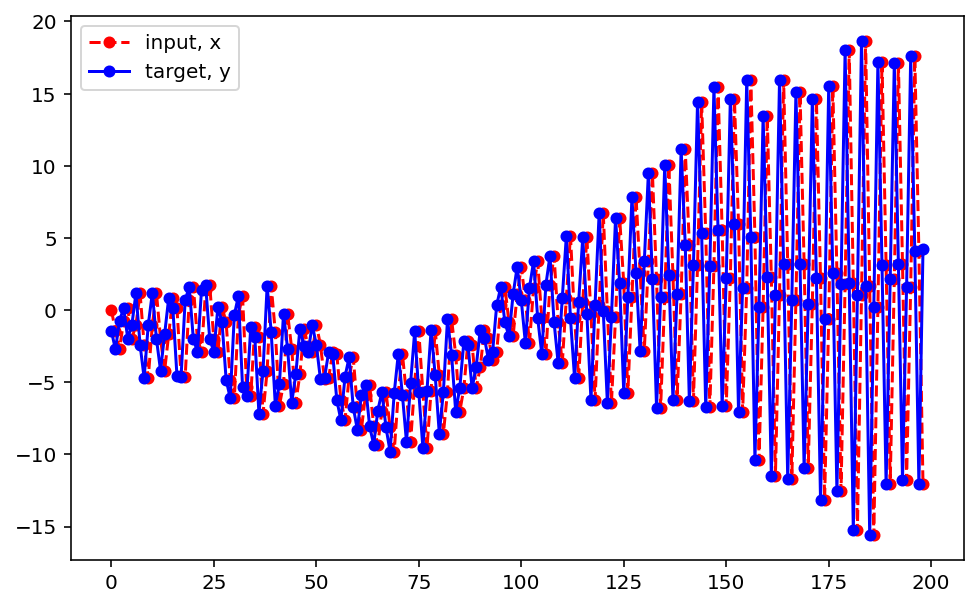

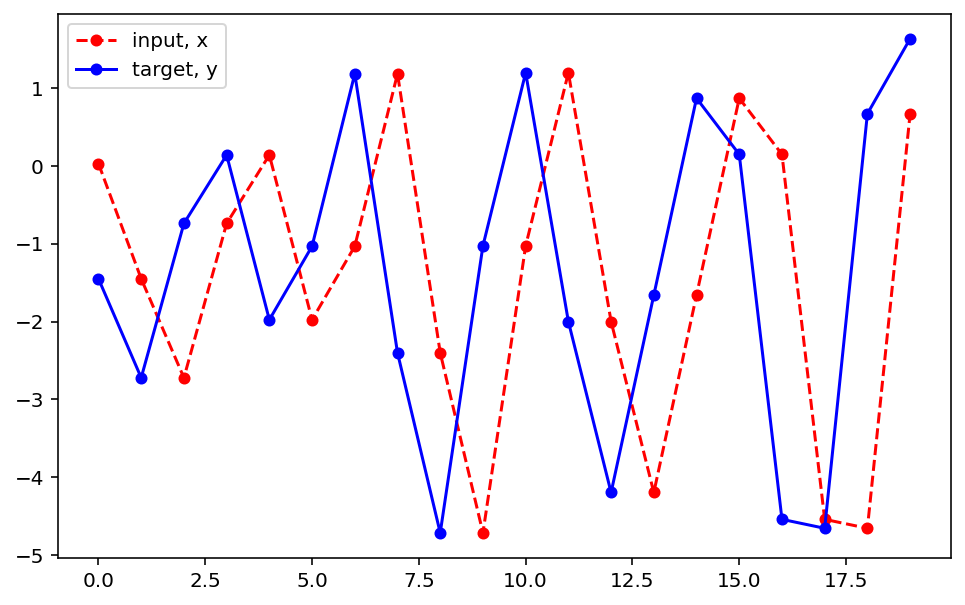

In [3]:
# Plot the signal 
plt.figure(figsize=(8,5))
plt.plot(np.arange(T), X[1,:T], 'r.--', label='input, x',ms=10) # x
plt.plot(np.arange(T), Y[1,:T], 'b.-', label='target, y',ms=10) # y

plt.legend(loc='best')

# Plot the signal (20 first steps)
plt.figure(figsize=(8,5))
plt.plot(np.arange(20), X[1,:20], 'r.--', label='input, x',ms=10) # x
plt.plot(np.arange(20), Y[1,:20], 'b.-', label='target, y',ms=10) # y

plt.legend(loc='best')

## Part II. Define RNN

Next, we define an RNN in PyTorch. We'll use `nn.RNN` to create an RNN layer, which takes in a number of parameters:
* **input_size** - the size of the input
* **hidden_dim** - the dimension of the RNN output and the hidden state
* **n_layers** - the number of layers that make up the RNN, typically 1-3; greater than 1 means that you'll create a **stacked RNN** 


This is an example of a stacked RNN

<img src="https://yiyibooks.cn/__src__/wizard/nmt-tut-neubig-2017_20180721165003_deleted/img/6-5.jpg" width="40%"> 


If you take a look at the [RNN documentation](https://pytorch.org/docs/stable/nn.html#rnn), you will see that `nn.RNN` only provides the actual computation of the hidden states along time
\begin{align}
h_{t}=g \left(W_{i h} x_{t}+b_{i h}+W_{h h} h_{(t-1)}+b_{h h}\right)
\end{align}

Then we'll add a last, fully-connected layer to get the output size that we want. For simplicity, **the input to this dense layer is the state $h_t$ of the RNN**.

You have to pay special attention to the dimensions of the input/output tensors of the RNN. **Check the [RNN documentation](https://pytorch.org/docs/stable/nn.html#rnn)**.




The following class implements a class where 
- An input signal of dimension `input_size` is processed by a RNN. As a result, we obtain a sequence of states $\mathbf{h}_{t}$, from $t=1$ to $t=T$.
- We process each state with a linear layer to estimate the output signal (of dimension `output_size`) at time $t$ from $\mathbf{h}_{t}$. 
- We sum a Gaussian noise of variance `sigma` to the output of the linear layer.

> **Exercise**: complete the following code. Understand all steps, particularly those in the `forward` method.

In [4]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers,sigma):
        
        # input size -> Dimension of the input signal
        # outpusize -> Dimension of the output signal
        # hidden_dim -> Dimension of the rnn state
        # n_layers -> If >1, we are using a stacked RNN
        
        super().__init__()
        
        self.hidden_dim = hidden_dim
        
        self.input_size = input_size
        
        self.sigma = sigma

        # define an RNN with specified parameters
        # batch_first=True means that the first dimension of the input will be the batch_size
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_dim, num_layers=n_layers, 
                          nonlinearity='relu',batch_first=True)
        
        # last, fully-connected layer
        self.fc1 = nn.Linear(in_features=hidden_dim,out_features= output_size) 

    def forward(self, x, h0=None):
        
        '''
        About the shape of the different tensors ...:
        
        - Input signal x has shape (batch_size, seq_length, input_size)
        - The initialization of the RNN hidden state h0 has shape (n_layers, batch_size, hidden_dim).
          If None value is used, internally it is initialized to zeros.
        - The RNN output (batch_size, seq_length, hidden_size). This output is the RNN state along time  

        '''
        
        batch_size = x.size(0) # Number of signals N
        seq_length = x.size(1) # T
        
        # get RNN outputs
        # r_out is the sequence of states
        # hidden is just the last state (we will use it for forecasting)
        r_out, hidden = self.rnn(x, h0)
        
        # shape r_out to be (seq_length, hidden_dim) #UNDERSTANDING THIS POINT IS IMPORTANT!!        
        r_out = r_out.reshape(-1, self.hidden_dim) 
        
        output = self.fc1(r_out)
        
        noise = torch.randn_like(output)*sigma
        
        output += noise
        
        # reshape back to temporal structure
        output = output.reshape([-1,seq_length,1])
        
        return output, hidden


> **Exercise:** Instantiate the object RNN with the right parameters for our problem. Use `hidden_dim=32`, `n_layers=1` and `sigma=1`

In [5]:
# YOUR CODE HERE
test_rnn = RNN(input_size=1,output_size=1,hidden_dim=32,n_layers=1,sigma=1)

In the following code, we compute the model output using the `forward` method. Note that we use an all zero initial state.

> **Exercise**: Complete the following code. What are the dimensions of variables `h` and `o`? How are these dimensions related to the number of signals, hidden state of the RNN and signal duration?

In [6]:
X_in = torch.Tensor(X).view([-1,T,1])

o,h = test_rnn.forward(X_in)

print(h.shape)
print(o.shape)

torch.Size([1, 1000, 32])
torch.Size([1000, 199, 1])


> **Exercise:** Complete the code for the following class, which extends `RNN` to include a training method. 

Note that there is no mini-batch, we process all signals for every SGD iteration. You are free to the mini-batch training functionality.

In [7]:
class RNN_extended(RNN):
    
    #Your code here
    
    def __init__(self, num_data_train, num_iter, sequence_length,
                 input_size, output_size, hidden_dim, n_layers, sigma, lr=0.001):
        
        super().__init__(input_size, output_size, hidden_dim, n_layers,sigma) 
        
        self.hidden_dim = hidden_dim
        
        self.sequence_length = sequence_length
        
        self.num_layers = n_layers
        
        self.lr = lr #Learning Rate
        
        self.num_train = num_data_train #Number of training signals
        
        self.optim = optim.Adam(self.parameters(), self.lr)
        
        self.num_iter = num_iter
        
        self.criterion = nn.MSELoss() #YOUR CODE HERE     
        
        # A list to store the loss evolution along training
        
        self.loss_during_training = [] 
        
           
    def trainloop(self,x,y):
        
        # SGD Loop
        
        for e in range(int(self.num_iter)):
        
            self.optim.zero_grad() 
                
            x = torch.Tensor(x).view([self.num_train,self.sequence_length ,1])  

            y = torch.Tensor(y).view([self.num_train,self.sequence_length ,1])   

            out,hid = self.forward(x)
                
            loss = self.criterion(out,y) 
            
            loss.backward()
            
            # This code helps to avoid vanishing exploiting gradients in RNNs
            # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
            nn.utils.clip_grad_norm_(self.parameters(), 2.0)
                
            self.optim.step()
                
            self.loss_during_training.append(loss.item()/self.num_iter)

            if(e % 50 == 0): # Every 10 iterations

                print("Iteration %d. Training loss: %f" %(e,self.loss_during_training[-1]))                

> **Exercise:** Using only the first 100 values of every signal, train the RNN for 100 SGD iterations. Use `hidden_dim=32`, `n_layers=1`,`lr=0.005`, and `sigma=1`. Recall that the target signal is stored in the variable `Y`.

In [9]:
T_train = 100

my_rnn = RNN_extended(num_data_train=X.shape[0],num_iter=200,sequence_length=T_train,
                     input_size=1,output_size=1,hidden_dim=32,n_layers=1,sigma=1.0,lr=0.005)

In [10]:
my_rnn.trainloop(X[:,:T_train],Y[:,:T_train])

Iteration 0. Training loss: 0.137194
Iteration 50. Training loss: 0.010838
Iteration 100. Training loss: 0.010210
Iteration 150. Training loss: 0.010117


> **Exercise:** Plot the loss function along training

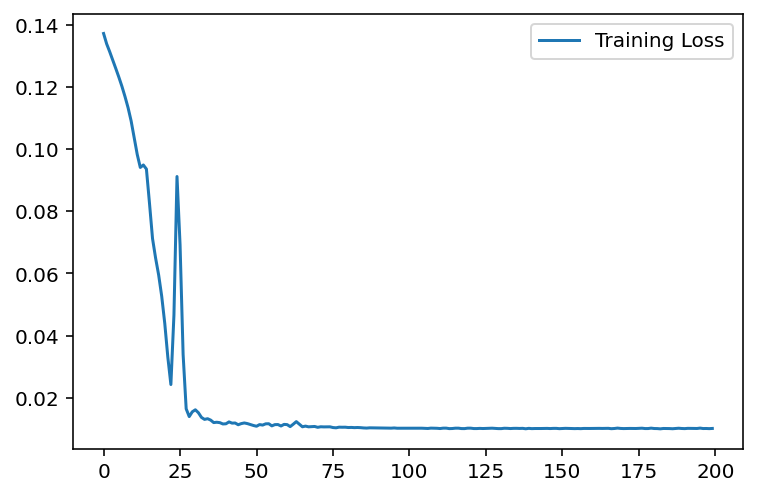

In [11]:
plt.plot(my_rnn.loss_during_training,label='Training Loss')
plt.legend()

> **Exercise:** Compute the following plot, in which we plot one of the input signals, the target one, and the predicted by the RNN from t=50 to t=100

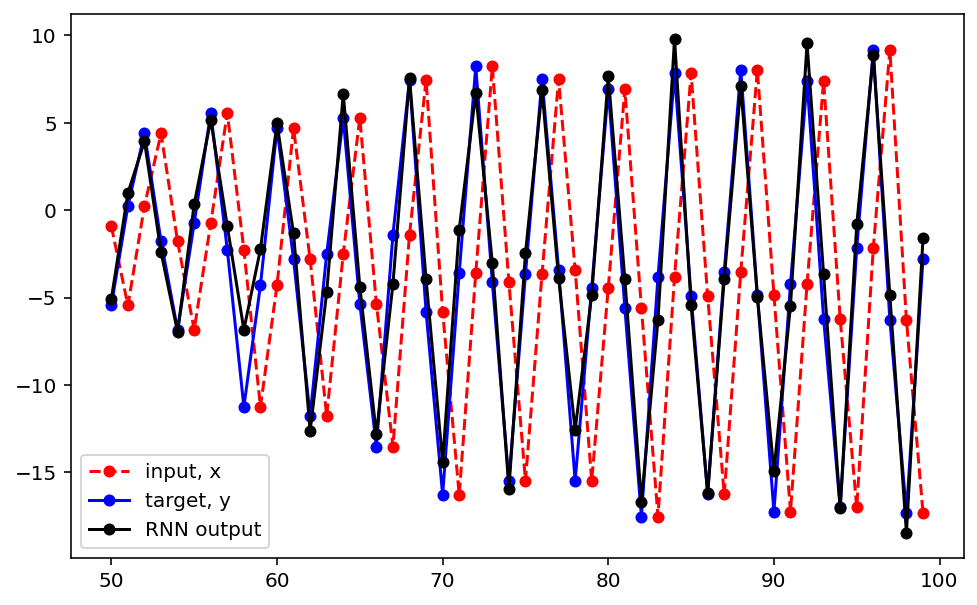

In [12]:
# We first evaluate the model for the N signals up to time T_train = 100
X_in = torch.Tensor(X[:,:T_train]).view(-1,T_train,1) 

o,h = my_rnn.forward(X_in) 

output_rnn = o.detach().numpy().reshape([N,-1])

offset = 50

signal = 0 # From 1 to N (you can play with this)

# Plot the first training signal and the target
plt.figure(figsize=(8,5))
plt.plot(np.arange(T_train-offset,T_train,1), X[signal,T_train-offset:T_train], 'r.--', label='input, x',ms=10) # x
plt.plot(np.arange(T_train-offset,T_train,1), Y[signal,T_train-offset:T_train], 'b.-', label='target, y',ms=10) # x
plt.plot(np.arange(T_train-offset,T_train,1), output_rnn[signal,T_train-offset:T_train], 'k.-', label='RNN output',ms=10) # y


plt.legend(loc='best')

Observe that the prediction is pretty good!The RNN model have clearly learnt the dynamics of the dataset. In the previous experiment, note we have fed the RNN model with the **true** values of the signal, i.e. we have used the full signal $X$ to compute the sequence of states. 

Using the model we have just trained, lets do now **forecasting**. Namely, we feed the RNN the output that we predicted and we do this recursively for as long as we want. This represents **sampling** from the probabilistic model 



$$p(X|X_{:T_{train}}) = \prod_{t=T_{train}}^T \mathcal{N}\left(f_{RNN}(X_{t-1},\mathbf{h}_{t-1}),\sigma^2\right)$$

To do forecasting, note that we have to recursively call the `forward` method and feed the obtained RNN output and state as the entry and initial state for the next `forward` call. The following code would do the job:

Between t=0 and t=100, we feed the real values
From t=100, we feed the estimated values (forecasting)


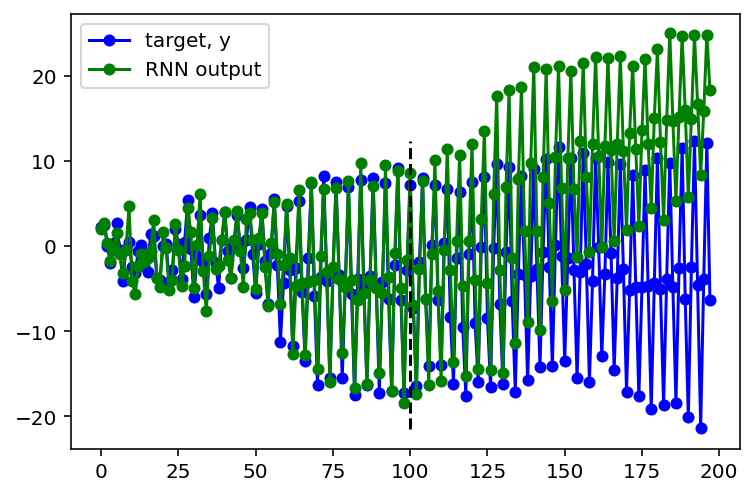

In [13]:
# We take the last RNN output 
current_input = o[:,-1,:].view([N,1,1]) #Note that current input only contains one observation for each of the N signals
# We take the last RNN state
current_state = h

forecast_rnn = np.zeros([N,T-T_train])

for t in range(T-T_train):
    
    # ... and feed them as input and initial state
    
    current_input,current_state = my_rnn.forward(current_input,current_state)
    
    forecast_rnn[:,t] = current_input.detach().numpy().reshape([-1,])
    
final_rnn_reconstruct = np.hstack([output_rnn,forecast_rnn])

# We plot the signal and the target before and after forecasting

plt.plot(np.arange(0,T-1,1), Y[signal,:-1].reshape([-1]), 'b.-', label='target, y',ms=10) 
plt.plot(np.arange(0,T-1,1), final_rnn_reconstruct[signal,:-1], 'g.-', label='RNN output',ms=10) 
plt.plot([T_train,T_train],[np.min(Y[signal,:]),np.max(Y[signal,:])],'k--')
plt.legend()

print('Between t=0 and t=100, we feed the real values')
print('From t=100, we feed the estimated values (forecasting)')

Observe that, during forecasting, sometimes the model quickly diverges from the target. That is **expected** we are sampling from the generative model and it is likely that do not get exactly the same sample! Particularly in RNN, since they have short memory.

## LSTMs

Lets study how an LSTM would perform in this context. You can create a basic [LSTM layer](https://pytorch.org/docs/stable/nn.html#lstm) as follows

```python
self.lstm = nn.LSTM(input_size, n_hidden, n_layers, 
                            dropout=drop_prob, batch_first=True)
```

where `input_size` is the number of characters this cell expects to see as sequential input, and `n_hidden` is the number of units in the hidden layers in the cell. If **stacked LSTMs (n_layers>1) are used** we can automatically add dropout between LSTM layers with te parameter `dropout` with a specified probability.

> **Exercise:** Complete the code for the following two classes 

In [14]:
class LSTM(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers,sigma,drop_prob):
        
        # input size -> Dimension of the input signal
        # outpusize -> Dimension of the output signal
        # hidden_dim -> Dimension of the rnn state
        # n_layers -> If >1, we are using a stacked RNN
        
        super().__init__()
        
        self.hidden_dim = hidden_dim
        
        self.input_size = input_size
        
        self.sigma = sigma

        # define an RNN with specified parameters
        # batch_first=True means that the first dimension of the input will be the batch_size

        #drop_prob = drop_prob if n_layers > 1 else 0
        self.lstm = nn.LSTM(input_size, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        
        # last, fully-connected layer
        self.fc1 = nn.Linear(in_features=hidden_dim,out_features= output_size)

    def forward(self, x, h0=None, valid=False):
        
        '''
        About the shape of the different tensors ...:
        
        - Input signal x has shape (batch_size, seq_length, input_size)
        - The initialization of the LSTM hidden state is a tuple, containing two tensors of dimensions
          (n_layers, batch_size, hidden_dim) each. The first tensor represents the LSTM hidden state 
          cell states. We can use the None value so internally they are initialized with 0s.
        - The LSTM output shape is (batch_size, seq_length, hidden_size) 

        '''
        
        # If we use stacked LSTMs, we have to control the evaluation mode due to the dropout between LSTMs
        if(valid):
            self.eval()
        else:
            self.train()
        
        batch_size = x.size(0) # Number of signals N
        seq_length = x.size(1) # T
        
        # get RNN outputs
        # r_out is the sequence of states
        # hidden is just the last state (we will use it for forecasting)
    
        r_out, hidden = self.lstm(x, h0)
        
        # shape r_out to be (seq_length, hidden_dim)    
        r_out = r_out.reshape(-1, self.hidden_dim) 
        
        output = self.fc1(r_out)
        
        noise = torch.randn_like(output)*sigma
        
        output += noise
        
        # reshape back to temporal structure
        output = output.reshape([-1,seq_length,1])
        
        return output, hidden


In [15]:
class LSTM_extended(LSTM):
    
    #Your code here
    
    def __init__(self, num_data_train, num_iter, sequence_length,
                 input_size, output_size, hidden_dim, n_layers, sigma, drop_prob=0.3, lr=0.001):
        
        super().__init__(input_size, output_size, hidden_dim, n_layers,sigma,drop_prob) 
        
        self.hidden_dim = hidden_dim
        
        self.sequence_length = sequence_length
        
        self.num_layers = n_layers
        
        self.lr = lr #Learning Rate
        
        self.num_train = num_data_train #Number of training signals
        
        self.optim = optim.Adam(self.parameters(), self.lr)
        
        self.num_iter = num_iter
        
        self.criterion = nn.MSELoss()
        
        # A list to store the loss evolution along training
        
        self.loss_during_training = [] 
        
           
    def trainloop(self,x,y):
        
        # SGD Loop
        
        for e in range(int(self.num_iter)):
        
            self.optim.zero_grad() 
                
            x = torch.Tensor(x).view([self.num_train,self.sequence_length,1 ]) #YOUR CODE HERE 

            y = torch.Tensor(y).view([self.num_train,self.sequence_length,1]) #YOUR CODE HERE 

            out,hid = self.forward(x) #YOUR CODE HERE 
                
            loss = self.criterion(out,y)  #YOUR CODE HERE 
            
            loss.backward()
            
            # This code helps to avoid vanishing exploiting gradients in RNNs
            # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
            nn.utils.clip_grad_norm_(self.parameters(), 2.0)
                
            self.optim.step()
                
            self.loss_during_training.append(loss.item()/self.num_iter)

            if(e % 50 == 0): # Every 10 iterations

                print("Iteration %d. Training loss: %f" %(e,self.loss_during_training[-1]))                

> **Exercise:** Train the LSTM model for 200 iterations using the first 100 values of each signal. Use `hidden_dim=32`, `n_layers=1`, `lr=0.005`, and `sigma=1`. Recall that the target signal is stored in the variable `Y`.
Note that with only one layer, the dropout probability parameter does not play any role (you will get a warning actually).


In [17]:
# YOUR CODE HERE
T_train = 100
my_lstm = LSTM_extended(
    num_data_train=X.shape[0],
    num_iter=200,
    sequence_length=T_train,
    input_size=1,
    output_size=1,
    hidden_dim=32,
    n_layers=1,
    lr=0.005,
    sigma=1
    )
my_lstm.train()
my_lstm.trainloop(X[:,:T_train],Y[:,:T_train])

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Iteration 0. Training loss: 0.138781
Iteration 50. Training loss: 0.076059
Iteration 100. Training loss: 0.019030
Iteration 150. Training loss: 0.011854


> **Exercise:** Plot the loss function along training


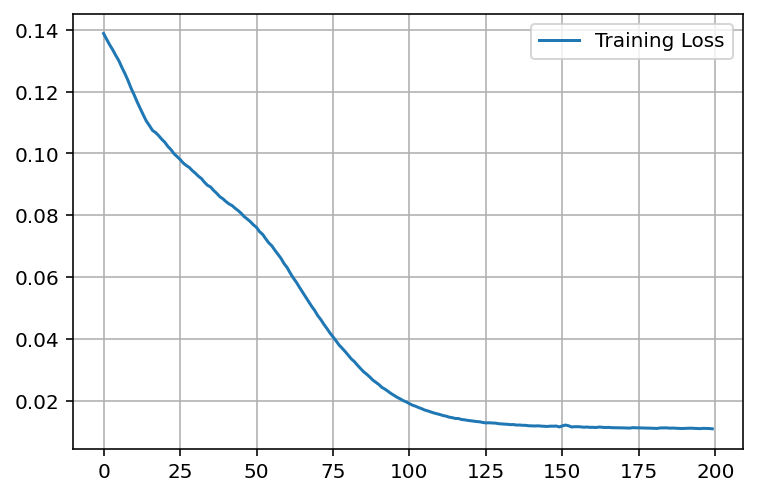

In [18]:
# YOUR CODE HERE
plt.plot(my_lstm.loss_during_training,label='Training Loss')
plt.grid()
plt.legend()
plt.show()

> **Exercise:** Complete the code to visualize the LSTM prediction of the next value of the signal

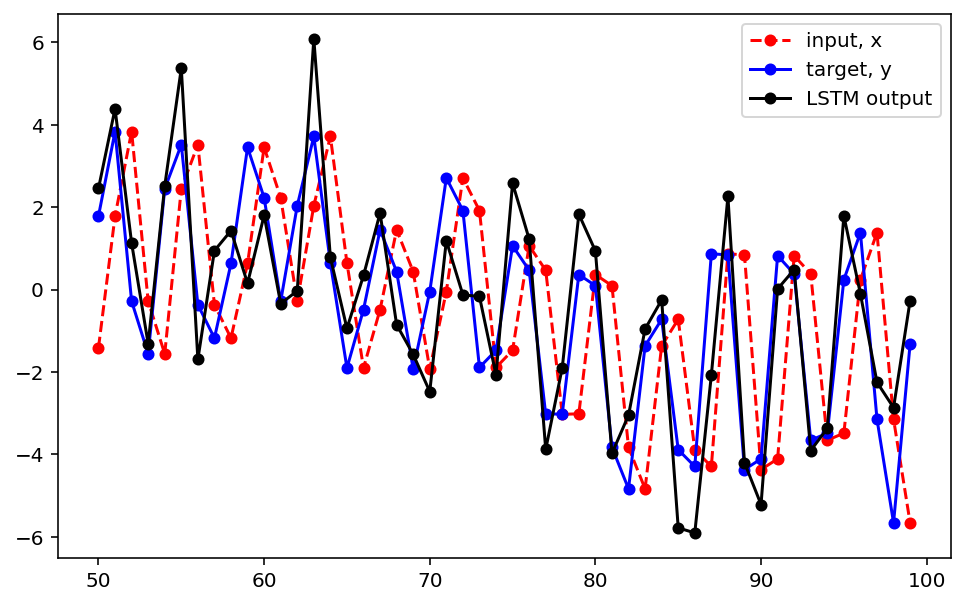

In [25]:
# We first evaluate the model for the N signals up to time T_train = 100
X_in = torch.tensor(X[:,:T_train]).view(-1,T_train,1) # YOUR CODE HERE
X_in = X_in.float()

o,h = my_lstm.forward(X_in) # YOUR CODE HERE)

output_lstm = o.detach().numpy().reshape([N,-1])
offset = 50
signal = 6 # From 1 to N (you can play with this)

# Plot the first training signal and the target
plt.figure(figsize=(8,5))
plt.plot(np.arange(T_train-offset,T_train,1), X[signal,T_train-offset:T_train], 'r.--', label='input, x',ms=10) # x
plt.plot(np.arange(T_train-offset,T_train,1), Y[signal,T_train-offset:T_train], 'b.-', label='target, y',ms=10) # x
plt.plot(np.arange(T_train-offset,T_train,1), output_lstm[signal,T_train-offset:T_train], 'k.-', label='LSTM output',ms=10) # y

plt.legend(loc='best')

> **Exercise:** Complete the code to visualize the LSTM forecasting. Plot the LSTM vs RNN vs target for a few signals and discuss the results.

Between t=0 and t=100, we feed the real values
From t=100, we feed the estimated values (forecasting)


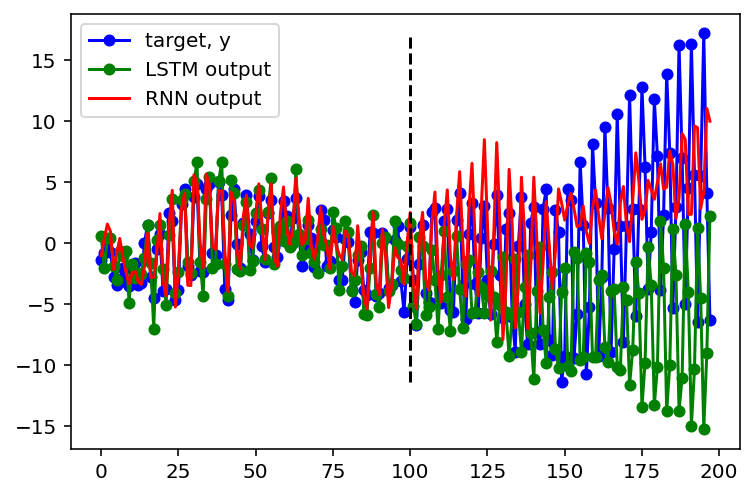

In [27]:
# We take the last RNN output 
current_input = o[:,-1,:].view([N,1,1]) #Note that current input only contains one observation for each of the N signals
# We take the last RNN state
current_state = h

forecast_lstm = np.zeros([N,T-T_train])

for t in range(T-T_train):
    
    # ... and feed them as input and initial state
    
    current_input,current_state = my_lstm.forward(current_input,current_state)
    
    forecast_lstm[:,t] = current_input.detach().numpy().reshape([-1,])
    
final_lstm_reconstruct = np.hstack([output_lstm,forecast_lstm])

# We plot the signal and the target before and after forecasting

signal = 6

plt.plot(np.arange(0,T-1,1), Y[signal,:-1].reshape([-1]), 'b.-', label='target, y',ms=10) 
plt.plot(np.arange(0,T-1,1), final_lstm_reconstruct[signal,:-1], 'g.-', label='LSTM output',ms=10) 
plt.plot(np.arange(0,T-1,1), final_rnn_reconstruct[signal,:-1], 'r-', label='RNN output',ms=10) 
plt.plot([T_train,T_train],[np.min(Y[signal,:]),np.max(Y[signal,:])],'k--')
plt.legend()

print('Between t=0 and t=100, we feed the real values')
print('From t=100, we feed the estimated values (forecasting)')

You should observe that the LSTM is able to keep track of the real signal during forecasting for a longer period of time.

> **Exercise (Optional):** Train an LSTM with 3 layers and evaluate the model.

In [29]:
# YOUR CODE HERE
lstm_3_layers = LSTM_extended(
    num_data_train=X.shape[0],
    num_iter=200,
    sequence_length=T_train,
    input_size=1,
    output_size=1,
    hidden_dim=32,
    n_layers=3,
    sigma=1,
    lr=0.005,
)
lstm_3_layers.train()
lstm_3_layers.trainloop(X[:,:T_train],Y[:,:T_train])

Iteration 0. Training loss: 0.137338
Iteration 50. Training loss: 0.072773
Iteration 100. Training loss: 0.021152
Iteration 150. Training loss: 0.016756


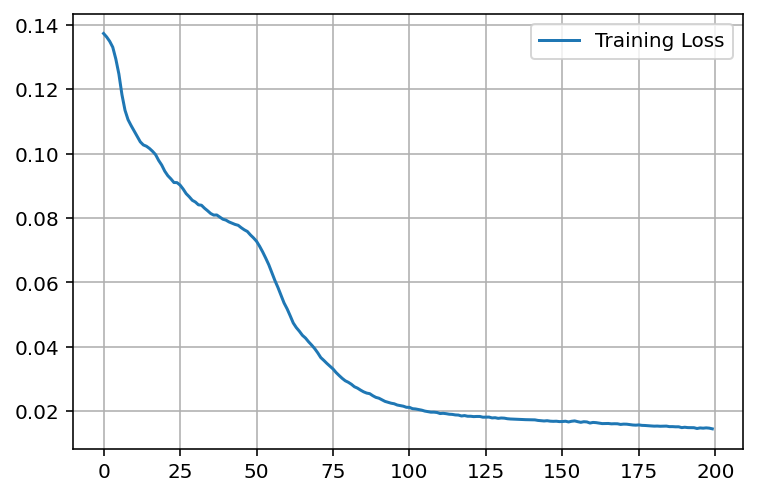

In [30]:
# YOUR CODE HERE
plt.plot(lstm_3_layers.loss_during_training,label='Training Loss')
plt.grid()
plt.legend()
plt.show()